In [1]:
using RigidBodyTreeInspector
using RigidBodyDynamics
using PyLCM
using BotCoreLCMTypes
import StaticArrays: SVector
import SimpleGradientDescent: NaiveSolver
import DataStructures: OrderedDict

INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/lib/v0.5/PyLCM.ji for module PyLCM.
INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/lib/v0.5/DrakeVisualizer.ji for module DrakeVisualizer.


adding: /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.5/DrakeVisualizer/src/lcmtypes to the python path


INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/lib/v0.5/RigidBodyTreeInspector.ji for module RigidBodyTreeInspector.


adding: /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/v0.5/DrakeVisualizer/src/lcmtypes to the python path


INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/lib/v0.5/BotCoreLCMTypes.ji for module BotCoreLCMTypes.


In [2]:
import Flash

INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/point-cloud-signed-distance/packages/lib/v0.5/SpatialFields.ji for module SpatialFields.


In [3]:
urdf = "$(ENV["HOME"])/locomotion/explorations/point-cloud-signed-distance/examples/data/IRB140/urdf/irb_140_convhull.urdf"
package_path = ["$(ENV["HOME"])/locomotion/drake-distro/drake/examples"]
model = Flash.Models.load_urdf(urdf; package_path=package_path)

Manipulator with 8 links and 7 surfaces

In [4]:
function table()

    mechanism = Mechanism(RigidBody{Float64}("world"))
    parent = root_body(mechanism)
    joint = Joint("joint1", QuaternionFloating{Float64}())
    joint_to_parent = Transform3D(Float64, joint.frameBefore, parent.frame)
    body = RigidBody(rand(SpatialInertia{Float64}, CartesianFrame3D("table_body")))
    body_to_joint = Transform3D(Float64, body.frame, joint.frameAfter)
    attach!(mechanism, parent, joint, joint_to_parent, body, body_to_joint)
    
    width = 0.5
    thickness = 0.05
    skeleton_points = Vector{Point3D{SVector{3, Float64}}}()
    surface_points = Vector{Point3D{SVector{3, Float64}}}()
    for z in [-thickness, thickness]
        for x in [-width, width]
            for y in [-width, width]
                push!(surface_points, Point3D(body.frame, SVector(x, y, z)))
            end
        end
    end
    geometries = OrderedDict(body => Flash.BodyGeometry(surface_points, skeleton_points))
    Flash.Manipulator(mechanism, [Flash.Surface(geometries, Flash.RigidPolytope())])
end
    

table (generic function with 1 method)

In [5]:
model = Flash.Models.load_urdf(urdf; package_path=package_path)
change_joint_type!(model.mechanism, model.mechanism.toposortedTree[2].edgeToParentData, QuaternionFloating{Float64}())

Flash.Models.merge!(model, Flash.Models.squishable())
Flash.Models.merge!(model, table())

Manipulator with 10 links and 9 surfaces

In [6]:
irb_floating_base = model.mechanism.toposortedTree[findfirst(
    v -> name(v.vertexData.frame) == "base_link", 
    model.mechanism.toposortedTree)].edgeToParentData

squishable_floating_base = model.mechanism.toposortedTree[findfirst(
    v -> name(v.vertexData.frame) == "squishable_body", 
    model.mechanism.toposortedTree)].edgeToParentData

table_floating_base = model.mechanism.toposortedTree[findfirst(
    v -> name(v.vertexData.frame) == "table_body", 
    model.mechanism.toposortedTree)].edgeToParentData

Joint "joint1": Quaternion floating joint

In [8]:
state = Flash.ManipulatorState(model);
configuration(state.mechanism_state, squishable_floating_base)[5:7] .= [0.55, 0.45, 0.8]
configuration(state.mechanism_state, irb_floating_base)[5:7] .= [0., 0, .75]
configuration(state.mechanism_state, table_floating_base)[5:7] .= [0.2, 0, 0.5]

# state.mechanism_state.q[end-2:end] = [0.5, 0, 0.25]
setdirty!(state.mechanism_state)
skin = Flash.skin(state);
Visualizer(DrakeVisualizer.contour_mesh(skin, [-.5, -.5, 0.5], [1., .5, 2], 0.01, 0.05))

DrakeVisualizer.Visualizer(DrakeVisualizer.Robot(DrakeVisualizer.Link[DrakeVisualizer.Link(DrakeVisualizer.GeometryData[DrakeVisualizer.GeometryData{CoordinateTransformations.IdentityTransformation,GeometryTypes.HomogenousMesh{FixedSizeArrays.Point{3,Float64},GeometryTypes.Face{3,Int64,0},Void,Void,Void,Void,Void}}(HomogenousMesh(
    vertices: 5012xFixedSizeArrays.Point{3,Float64},     faces: 9780xGeometryTypes.Face{3,Int64,0}, )
,CoordinateTransformations.IdentityTransformation(),RGBA{Float64}(1.0,0.0,0.0,0.5))],"link")]),1,PyLCM.LCM(PyObject <LCM object at 0x7f7d367cfcf0>))

In [9]:
lc = LCM()

PyLCM.LCM(PyObject <LCM object at 0x7f7d1c994150>)

In [10]:
log = PyLCM.pylcm[:EventLog]("/home/rdeits/Desktop/squishable/squishable_squish_out.lcm");

In [11]:
msg = PyNULL()
for event in log
    if event[:channel] == "KINECT_POINTS_REDUCED"
        @show event
        msg = bot_core[:pointcloud_t][:decode](event["data"])
        publish(lc, "DRAKE_POINTCLOUD_kinect", msg)
        break
    end
end

event = PyObject <lcm.Event object at 0x7f7d1c92ad90>


In [12]:
extract_points(msg) = map(SVector{3, Float64}, msg[:points])

extract_points (generic function with 1 method)

In [13]:
sensed_points = extract_points(msg)[1:200:end]
Flash.DepthSensors.draw_points(sensed_points)

In [21]:
function test_gradient_descent(model, initial_state, sensed_points, loops)
    solver = NaiveSolver(Flash.num_states(model); rate=1.0, max_step=0.1, iteration_limit=1)
    
    for i = 1:loops
        
        function callback{T}(x::AbstractVector{T}, c)
            x_value = Flash.value.(x)
            state = Flash.ManipulatorState(model)
            Flash.GradientDescent.unflatten!(state, x_value)
#             Flash.draw(state, false)
#             skin = Flash.skin(state);
#             Visualizer(DrakeVisualizer.contour_mesh(skin, [-.5, -.5, 0.5], [1., .5, 2], 0.01, 0.05))
        end
        
        Flash.draw(initial_state, false)
        x_estimated = Flash.flatten(initial_state)
        Flash.Tracking.estimate_state(model, sensed_points, x_estimated; callback=callback, solver=solver)
    end
end

test_gradient_descent (generic function with 1 method)

In [22]:
using ProfileView

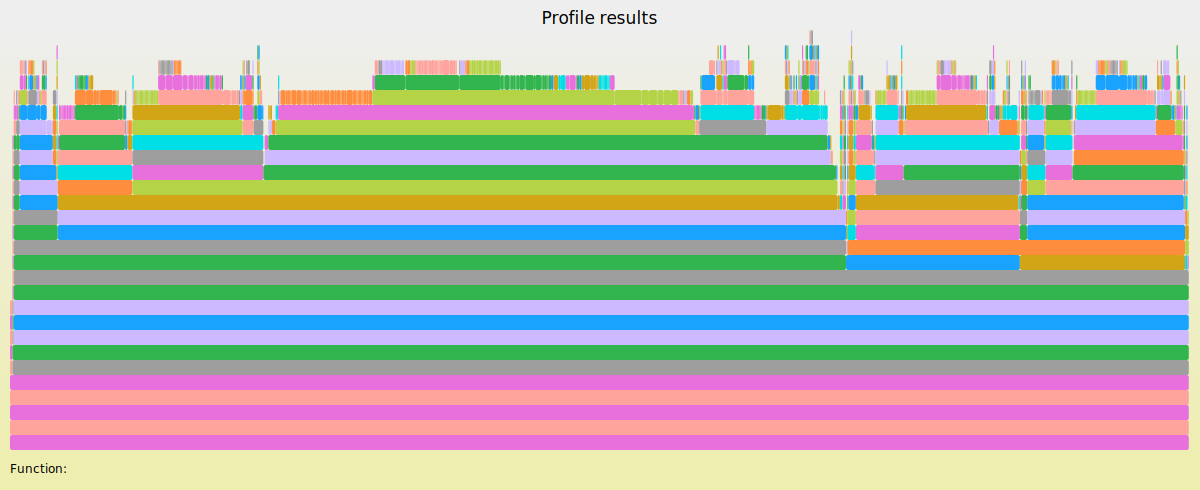

In [23]:
test_gradient_descent(model, state, sensed_points, 1)
Profile.clear()
@profile test_gradient_descent(model, state, sensed_points, 1)
ProfileView.view()